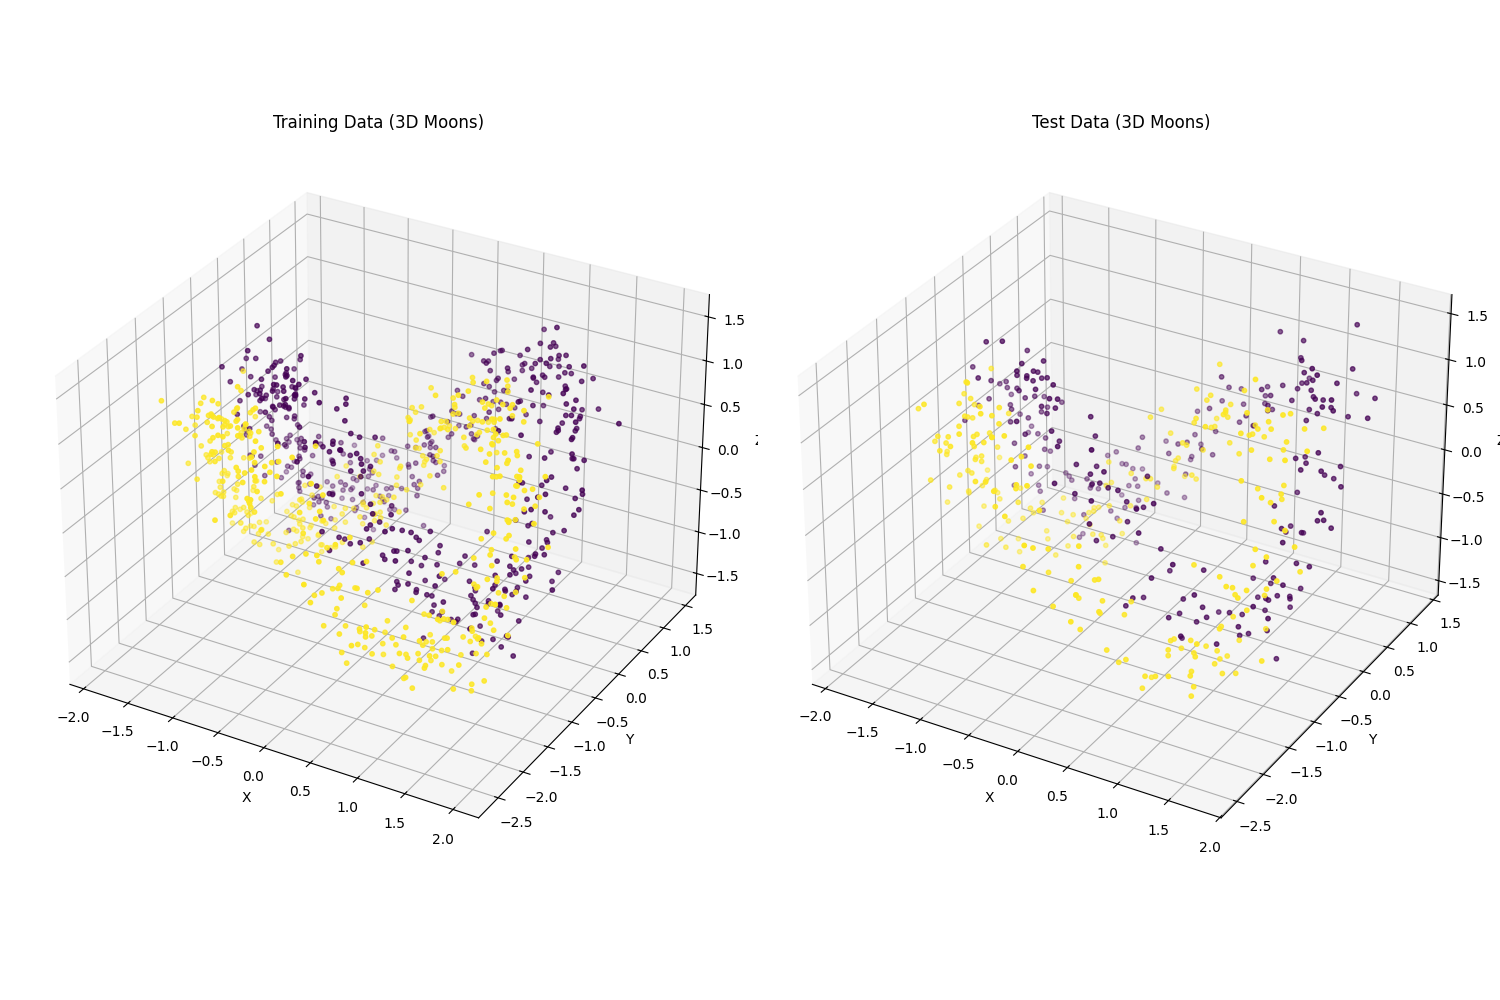

Decision Tree: Accuracy = 0.9260
AdaBoost: Accuracy = 0.7600
SVM Linear: Accuracy = 0.6640
SVM RBF: Accuracy = 0.9800
SVM Poly: Accuracy = 0.7460


In [10]:
%matplotlib widget
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score



import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
# Generating 3D make-moons data
def make_moons_3d(n_samples=500, noise=0.1):
    # Generate the original 2D make_moons data
    t = np.linspace(0, 2 * np.pi, n_samples)
    x = 1.5 * np.cos(t)
    y = np.sin(t)
    z = np.sin(2 * t)  # Adding a sinusoidal variation in the third dimension

    # Concatenating the positive and negative moons with an offset and noise
    X = np.vstack([np.column_stack([x, y, z]), np.column_stack([-x, y - 1, -z])])
    y = np.hstack([np.zeros(n_samples), np.ones(n_samples)])

    # Adding Gaussian noise
    X += np.random.normal(scale=noise, size=X.shape)

    return X, y
# 生成训练数据（1000样本，两类各500）
X_train, y_train = make_moons_3d(n_samples=500, noise=0.2)

# 生成测试数据（500样本，两类各250）
X_test, y_test = make_moons_3d(n_samples=250, noise=0.2)

# 绘制原始训练数据分布
fig = plt.figure(figsize=(15, 10))
ax = fig.add_subplot(121, projection='3d')
scatter = ax.scatter(X_train[:, 0], X_train[:, 1], X_train[:, 2], c=y_train, cmap='viridis', s=10)
ax.set_title('Training Data (3D Moons)')
ax.set_xlabel('X'), ax.set_ylabel('Y'), ax.set_zlabel('Z')

# 绘制测试数据分布
ax_test = fig.add_subplot(122, projection='3d')
scatter_test = ax_test.scatter(X_test[:, 0], X_test[:, 1], X_test[:, 2], c=y_test, cmap='viridis', s=10)
ax_test.set_title('Test Data (3D Moons)')
ax_test.set_xlabel('X'), ax_test.set_ylabel('Y'), ax_test.set_zlabel('Z')

plt.tight_layout()
plt.show()

# 标准化数据
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 初始化分类器
dt = DecisionTreeClassifier(random_state=42)
ada = AdaBoostClassifier(n_estimators=50, random_state=42)
svm_linear = SVC(kernel='linear', random_state=42)
svm_rbf = SVC(kernel='rbf', random_state=42)
svm_poly = SVC(kernel='poly', degree=3, random_state=42)

# 训练并评估模型
classifiers = {
    'Decision Tree': dt,
    'AdaBoost': ada,
    'SVM Linear': svm_linear,
    'SVM RBF': svm_rbf,
    'SVM Poly': svm_poly
}

results = {}
for name, clf in classifiers.items():
    clf.fit(X_train_scaled, y_train)
    y_pred = clf.predict(X_test_scaled)
    results[name] = accuracy_score(y_test, y_pred)

# 打印结果
for name, acc in results.items():
    print(f"{name}: Accuracy = {acc:.4f}")

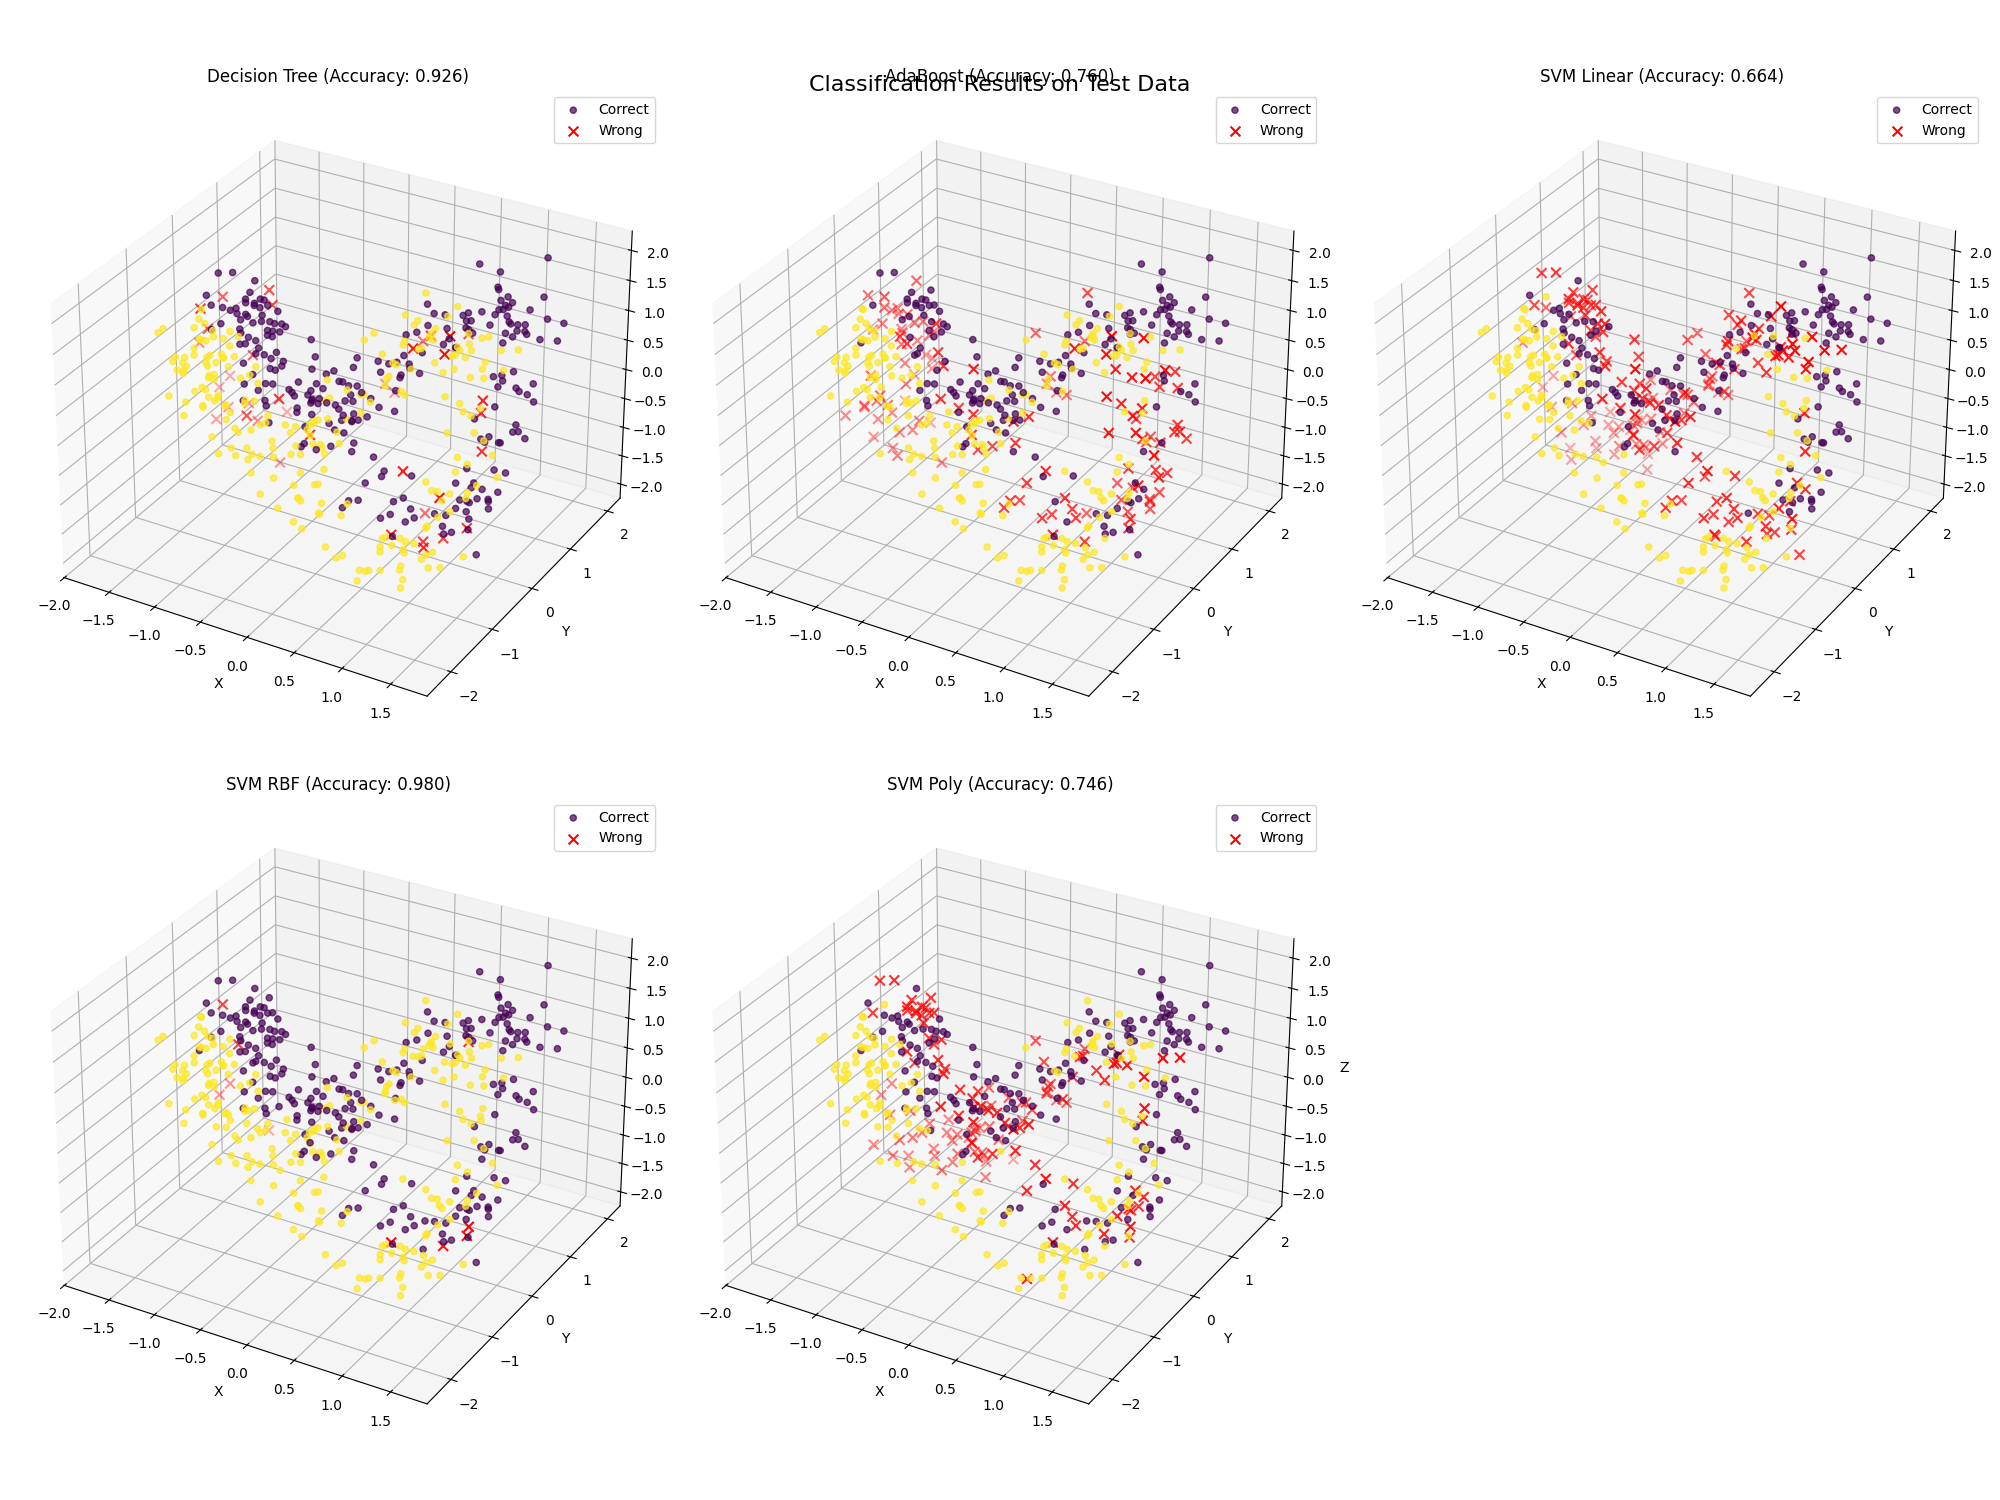

In [11]:
# 绘制各分类器在测试集上的预测结果
fig = plt.figure(figsize=(20, 15))
fig.suptitle('Classification Results on Test Data', y=0.95, fontsize=16)

# 为每个分类器生成子图
for i, (name, clf) in enumerate(classifiers.items()):
    ax = fig.add_subplot(2, 3, i+1, projection='3d')
    y_pred = clf.predict(X_test_scaled)
    
    # 标记正确分类（绿色）和错误分类（红色）
    correct = (y_pred == y_test)
    incorrect = ~correct
    
    # 绘制正确点
    ax.scatter(X_test_scaled[correct, 0], X_test_scaled[correct, 1], X_test_scaled[correct, 2], 
               c=y_test[correct], cmap='viridis', s=20, label='Correct', alpha=0.7)
    # 绘制错误点
    ax.scatter(X_test_scaled[incorrect, 0], X_test_scaled[incorrect, 1], X_test_scaled[incorrect, 2], 
               c='red', s=50, marker='x', label='Wrong')
    
    ax.set_title(f'{name} (Accuracy: {results[name]:.3f})')
    ax.set_xlabel('X'), ax.set_ylabel('Y'), ax.set_zlabel('Z')
    ax.legend()

plt.tight_layout()
plt.show()

In [13]:
# 定义3D决策边界绘制函数
def plot_3d_boundary(clf, scaler, ax, resolution=30):
    # 动态计算数据范围
    scaled_data = scaler.transform(np.vstack([X_train, X_test]))
    x_min, x_max = scaled_data[:,0].min()-0.5, scaled_data[:,0].max()+0.5
    y_min, y_max = scaled_data[:,1].min()-0.5, scaled_data[:,1].max()+0.5
    z_min, z_max = scaled_data[:,2].min()-0.5, scaled_data[:,2].max()+0.5
    
    # 生成网格
    x_range = np.linspace(x_min, x_max, resolution)
    y_range = np.linspace(y_min, y_max, resolution)
    z_range = np.linspace(z_min, z_max, resolution)
    xx, yy, zz = np.meshgrid(x_range, y_range, z_range)
    grid = np.c_[xx.ravel(), yy.ravel(), zz.ravel()]
    
    # 获取连续输出（概率或决策函数）
    if hasattr(clf, 'decision_function'):
        values = clf.decision_function(scaler.transform(grid))
        level = 0
    else:
        values = clf.predict_proba(scaler.transform(grid))[:,1]
        level = 0.5
    
    # 提取等值面
    values_3d = values.reshape(xx.shape)
    verts, faces, _, _ = measure.marching_cubes(values_3d, level=level, 
                                               spacing=(x_range[1]-x_range[0], 
                                                       y_range[1]-y_range[0], 
                                                       z_range[1]-z_range[0]))
    verts += [x_range[0], y_range[0], z_range[0]]
    
    # 绘制边界（半透明青色）
    mesh = Poly3DCollection(verts[faces], alpha=0.2, edgecolor='none', facecolor='cyan')
    ax.add_collection3d(mesh)

# 创建可视化画布
fig = plt.figure(figsize=(20, 15))
plt.suptitle("3D Classification Results with Decision Boundaries", y=0.95, fontsize=16)

# 为每个分类器绘制子图
for idx, (name, clf) in enumerate(classifiers.items()):
    ax = fig.add_subplot(2, 3, idx+1, projection='3d')
    # 绘制测试数据点
    y_pred = clf.predict(X_test_scaled)
    correct = y_pred == y_test
    # 正确分类点（颜色对应真实类别）
    ax.scatter(X_test_scaled[correct, 0], X_test_scaled[correct, 1], X_test_scaled[correct, 2],
               c=y_test[correct], cmap='viridis', s=20, alpha=0.7, depthshade=False)
    # 错误分类点（红色叉号）
    ax.scatter(X_test_scaled[~correct, 0], X_test_scaled[~correct, 1], X_test_scaled[~correct, 2],
               c='red', s=50, marker='x', alpha=1, depthshade=False)

    
    # 绘制决策边界
    plot_3d_boundary(clf, scaler, ax, resolution=30)
    
    ax.set_title(f"{name}\nAccuracy: {results[name]:.3f}", pad=10)
    ax.set_xlabel('X'), ax.set_ylabel('Y'), ax.set_zlabel('Z')
    ax.view_init(elev=25, azim=-45)  # 初始视角设置

plt.tight_layout()
plt.show()